In [46]:
import copy
import PIL
import warnings
import pandas as pd
import numpy as np
import matplotlib.dates as mdates   
import matplotlib.pyplot as plt
import seaborn as sns
from model import Company, StockLog, IndexLog, PerformanceLog
from model import start_engine
from datetime import date, datetime
import plotly as py
import plotly.graph_objs as go

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set()

In [47]:
engine = start_engine()

In [13]:
def get_candle(stock, start='2009-07-01', finish=None, engine=engine):
    if not engine:
        engine = start_engine()
    start = datetime.strptime(start, '%Y-%m-%d').date()
    if finish:
        finish = datetime.strptime(finish, '%Y-%m-%d').date()
    else:
        finish = datetime.today()
    company = Company().query().get(stock)
    stock_log = StockLog().query().filter((StockLog.company == company) &
                                          (StockLog.date >= start) &
                                          (StockLog.date <= finish))
    df = pd.read_sql(stock_log.statement, engine)
    df.sort_values(by='date', inplace=True)
    df.set_index('date', inplace=True)
    
    fig = go.Figure()
    trace = go.Candlestick(x=df.index,
                           open=df['opening'],
                           high=df['high'],
                           low=df['low'],
                           close=df['closing'])
    fig.add_trace(trace)
    fig.update_layout(title=go.layout.Title(text='%s Candlestick Chart' % stock, xref="paper", x=0))
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.write_image('candle.png')
    img = PIL.Image.open('candle.png')
    return img      

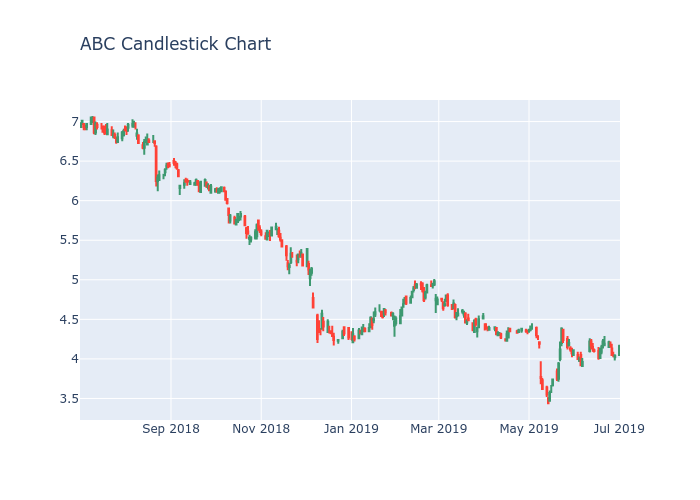

In [14]:
get_candle('ABC', start='2018-07-01', finish='2019-07-01')

In [3]:
def get_plot(
    stocks = [],                # list of stocks 
    indicies = [],              # list of fundamental indicies
    size = (12, 4),             # graph (length, height)
    start = '2009-07-01',       # start date in 'YYYY-MM-DD' format
    finish = None,              # finish date in 'YYYY-MM-DD' format
    title = None,               # graph title
    change = False,             # daily percentage change
    norm = 'mean',              # normalization method: mean, minmax
    micro = False,              # micro plot
    engine = engine,
    # observations
    opening = False,
    high = False,
    low = False,
    closing = False,
    adjusted = False,
    volume = False,
    # technicals
    sma15 = False,
    sma50 = False,
    sma200 = False,
    ema15 = False,
    ema50 = False,
    ema200 = False,
    macd = False,
    bb = False,
    stoch = False,
    rsi = False,
    adx = False,
    cci = False,
    aroon = False,
    chaikin = False,
    obv = False,
    mom = False,
    # fundamentals
    pe_ratio = False,
    dp_ratio = False,
    pb_ratio = False):
    
    if (len(stocks) == 0) and (len(indicies) == 0):
        raise Exception('Empty list')
    
    if not engine:
        engine = start_engine()

    (x, y) = size
    if not micro:
        plt.figure(figsize=(x, y), dpi=100)
      
    start = datetime.strptime(start, '%Y-%m-%d').date()
    if finish:
        finish = datetime.strptime(finish, '%Y-%m-%d').date()
    else:
        finish = datetime.today()        
     
    companies = [Company().query().get(stock) for stock in stocks]
    for company in companies:
        stock_log = StockLog().query().filter((StockLog.company == company) &
                                               (StockLog.date >= start) &
                                               (StockLog.date <= finish))
        df = pd.read_sql(stock_log.statement, engine)
        df.sort_values(by='date', inplace=True)
        df.set_index('date', inplace=True)
        if len(companies) > 1:
            if norm == 'minmax':
                df['closing'] = (df['closing'] - df['closing'].min()) / (df['closing'].max() - df['closing'].min())
            else:
                df['closing'] = (df['closing'] - df['closing'].mean()) / df['closing'].std()
            plt.plot(df.index, df['closing'], label='Closing of %s'% company.code)  

    if opening:
        plt.plot(df.index, df['opening'], label='Opening of %s' % company.code)
    if high:
        plt.plot(df.index, df['high'], label='High of %s' % company.code)
    if low:
        plt.plot(df.index, df['low'], label='Low of %s' % company.code)
    if closing:
        plt.plot(df.index, df['closing'], c='r', label='Closing of %s' % company.code)        
    if adjusted:
        plt.plot(df.index, df['adjusted'], label='Adjusted close of %s' % company.code)
    if change:
        df['change_pct'] = df['change_pct'] * 100
        plt.plot(df.index, df['change_pct'], label='Change in percent of %s' % company.code)  
        plt.axhline(y=0.0, color='r', linestyle='--')
    if sma15:
        plt.plot(df.index, df['sma15'], linestyle='--', label='SMA15 of %s' % company.code)
    if sma50:
        plt.plot(df.index, df['sma50'], linestyle='--', label='SMA50 of %s' % company.code)
    if sma200:
        plt.plot(df.index, df['sma200'], linestyle='--', label='SMA200 of %s' % company.code)        
    if ema15:
        plt.plot(df.index, df['ema15'], linestyle='--', label='EMA15 of %s' % company.code)
    if ema50:
        plt.plot(df.index, df['ema50'], linestyle='--', label='EMA50 of %s' % company.code)
    if ema200:
        plt.plot(df.index, df['ema200'], linestyle='--', label='EMA200 of %s' % company.code) 
    if macd:
        plt.plot(df.index, df['macd'], label='MACD of %s' % company.code)
        plt.plot(df.index, df['macd_sig'], label='Signal of %s' % company.code)
        plt.bar(df.index, df['macd_hist'], color='green', linewidth=1, edgecolor='green')
        plt.axhline(y=0.0, color='r', linestyle='--')
    if bb:
        plt.plot(df.index, df['closing'], c='r', label='Closing of %s' % company.code)   
        plt.plot(df.index, df['bb_hi'], c='c', linestyle='--', label='BB Hi of %s' % company.code)
        plt.plot(df.index, df['bb_lo'], c='c', linestyle='--', label='BB Lo of %s' % company.code)
        plt.fill_between(df.index, df['bb_lo'], df['bb_hi'], alpha=0.25)
    if stoch:
        plt.plot(df.index, df['slowk'], label='Slow K of %s' % company.code)
        plt.plot(df.index, df['slowd'], label='Slow D of %s' % company.code)
        plt.axhline(y=80, c='r', linestyle='--')
        plt.axhline(y=20, c='r', linestyle='--')
        plt.ylim(0, 100)
    if rsi:
        plt.plot(df.index, df['rsi'], label='RSI of %s' % company.code) 
        plt.axhline(y=70, c='r', linestyle='--')
        plt.axhline(y=30, c='r', linestyle='--')   
        plt.ylim(0, 100)
    if adx:
        plt.plot(df.index, df['adx'], label='ADX of %s' % company.code)         
        plt.axhline(y=25, c='r', linestyle='--')   
        plt.ylim(0, 100)
    if cci:
        plt.plot(df.index, df['cci'], label='CCI of %s' % company.code)         
        plt.axhline(y=100, c='r', linestyle='--')
        plt.axhline(y=-100, c='r', linestyle='--')         
    if aroon:
        plt.plot(df.index, df['aroon_up'], label='Aroon Up  of %s' % company.code)  
        plt.plot(df.index, df['aroon_dn'], label='Aroon Down of %s' % company.code)  
        plt.ylim(-10, 110)
    if chaikin:
        plt.plot(df.index, df['chaikin'], label='Chaikin A/D  of %s' % company.code)  
        plt.axhline(y=0, c='r', linestyle='--')
    if obv:
        plt.plot(df.index, df['obv'], label='OBV of %s' % company.code)  
    if mom:
        plt.plot(df.index, df['mom'], label='Momentum of %s' % company.code)  
        plt.axhline(y=0, c='r', linestyle='--')
    if pe_ratio:
        df['pe_ratio'] = df['pe_ratio'] * 100
        plt.plot(df.index, df['pe_ratio'], label='Price-to-Earnings Ratio of %s' % company.code) 
    if dp_ratio:
        plt.plot(df.index, df['dp_ratio'], label='Dividend Yield of %s' % company.code) 
    if pb_ratio:
        plt.plot(df.index, df['pb_ratio'], label='Price-to-BV Ratio of %s' % company.code)
    if micro:
        plt.figure(figsize=(1, 0.33), dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        df['micro'] = (df['closing'] - df['closing'].mean()) / df['closing'].std()
        plt.plot(df.index, df['micro'])          
        plt.axhline(y=0, c='r', linewidth=1, linestyle='--')  
    if volume:
        plt.bar(df.index, df['volume'], color='green', label='Volume of %s' % company.code, linewidth=1, edgecolor='green')
        
    if len(indicies) > 0:
        index_log = IndexLog().query().filter((IndexLog.date >= start) & (IndexLog.date <= finish) & (IndexLog.index.in_(indicies)))
        fi = pd.read_sql(index_log.statement, engine)
        for idx in indicies:
            new = fi.loc[fi['index'] == idx]
            new = new.rename(columns={'value': idx})
            new.sort_values(by='date', inplace=True)
            new.set_index('date', inplace=True)
            new.drop(new.columns[[0]], axis=1, inplace=True)
            if norm == 'minmax':
                new[idx] = (new[idx] - new[idx].min) / (new[idx].max() - new[idx].min())
            else:
                new[idx] = (new[idx] - new[idx].mean()) / new[idx].std()
            plt.plot(new.index, new[idx], label='%s index' % idx.capitalize()) 
        if len(companies) > 0:
            if norm == 'minmax':
                df['closing'] = (df['closing'] - df['closing'].min()) / (df['closing'].max() - df['closing'].min())
            else:
                df['closing'] = (df['closing'] - df['closing'].mean()) / df['closing'].std()
            plt.plot(df.index, df['closing'], label='Closing of %s'% company.code)  

    if not micro:
        plt.legend()
    plt.savefig('plot.png', format='png')
    plt.close()     
    img = PIL.Image.open('plot.png')
    return img

In [4]:
stock = 'ABC'

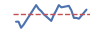

In [5]:
get_plot([stock], micro=1, start='2019-06-01', finish='2019-07-01')

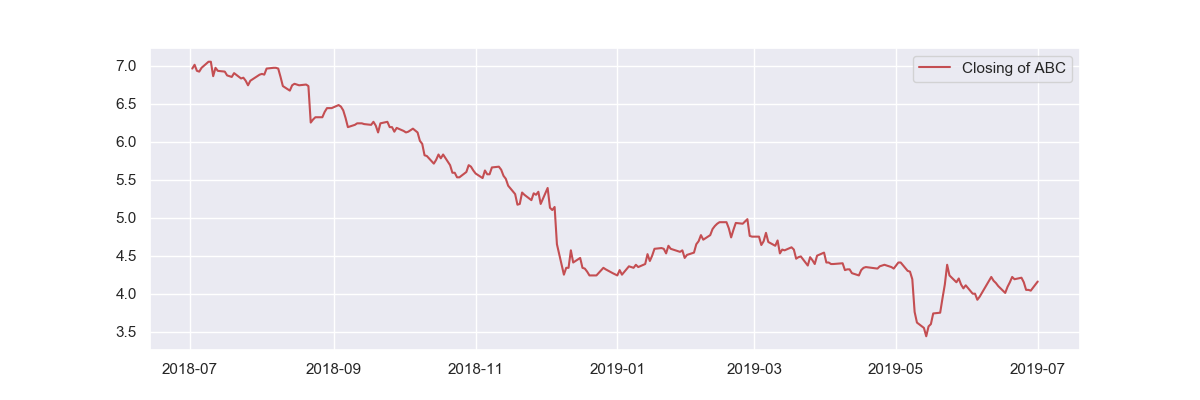

In [6]:
get_plot([stock], closing=1, start='2018-07-01', finish='2019-07-01')

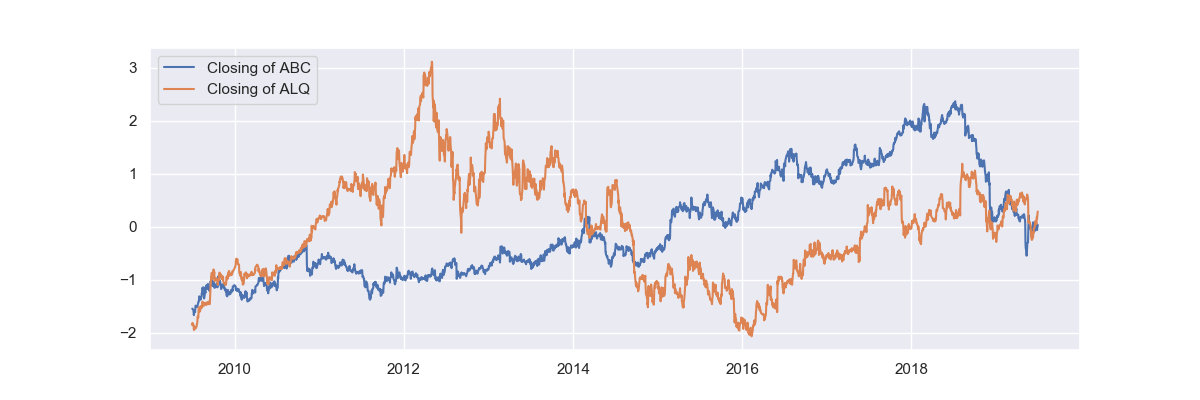

In [12]:
get_plot([stock, 'ALQ'], norm='mean', start='2009-07-01', finish='2019-07-01')

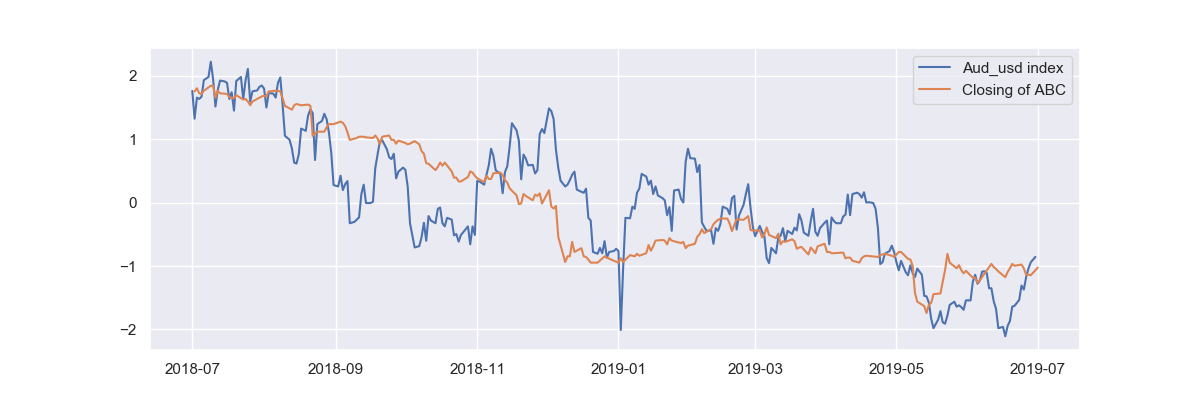

In [17]:
get_plot([stock], indicies=['aud_usd'], start='2018-07-01', finish='2019-07-01')

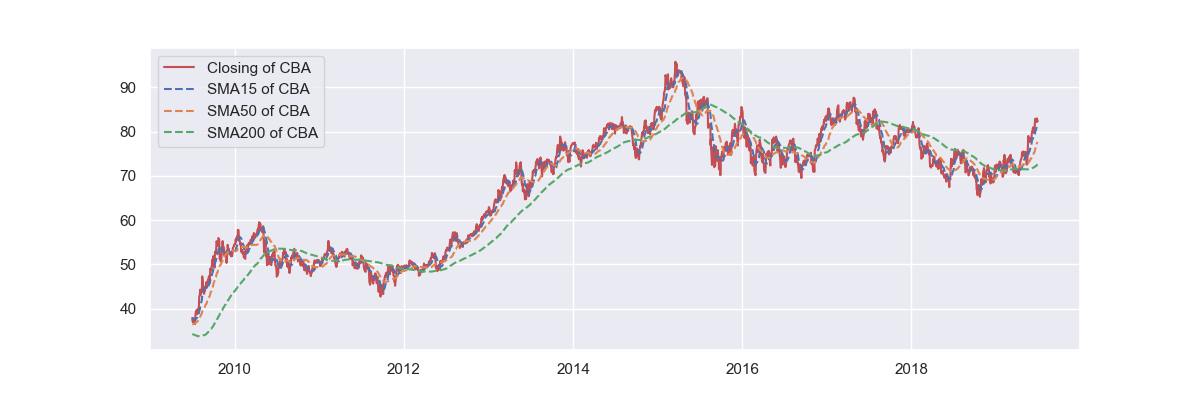

In [141]:
get_plot([stock], closing=1, sma15=1, sma50=1, sma200=1, start='2009-07-01', finish='2019-07-01')

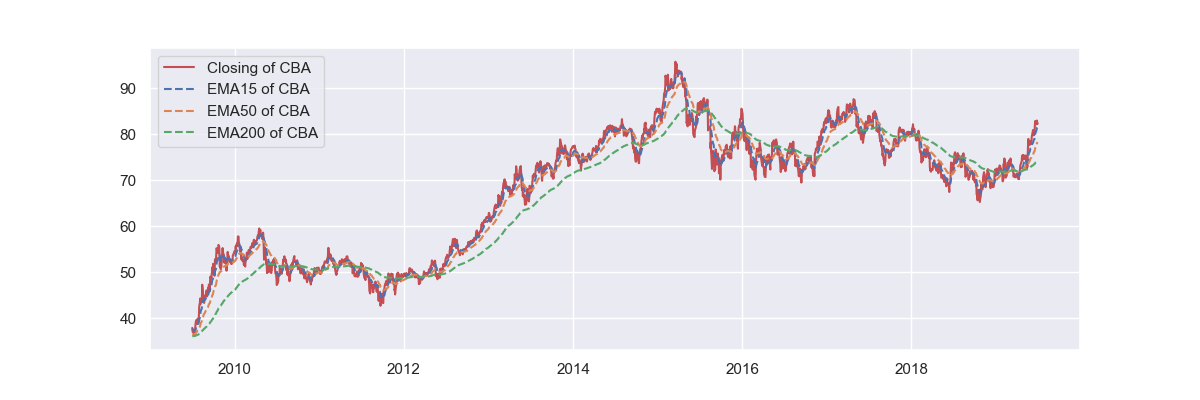

In [142]:
get_plot([stock], closing=1, ema15=1, ema50=1, ema200=1, start='2009-07-01', finish='2019-07-01')

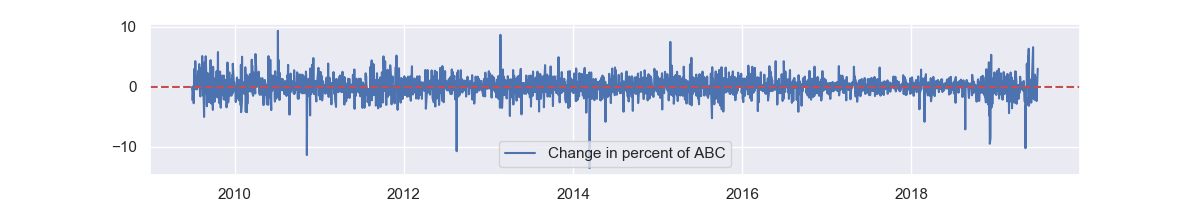

In [154]:
get_plot([stock], size=(12, 2), change=1, start='2009-07-01', finish='2019-07-01')

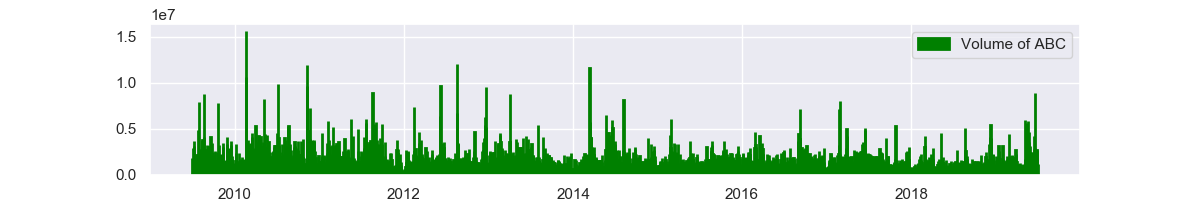

In [233]:
get_plot([stock], volume=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

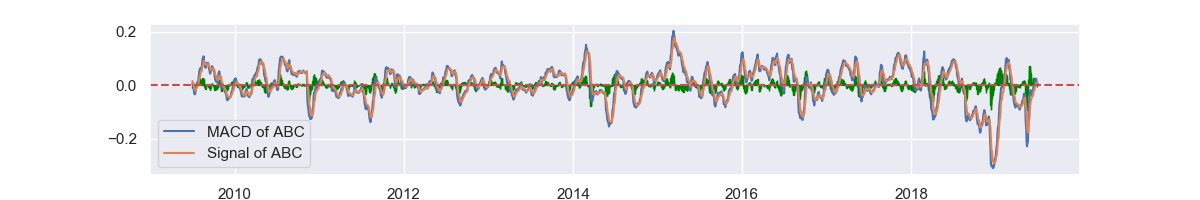

In [237]:
get_plot([stock], macd=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

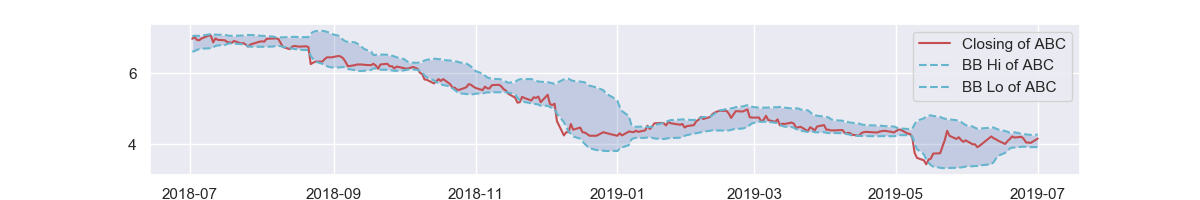

In [18]:
get_plot([stock], bb=1, size=(12, 2), start='2018-07-01', finish='2019-07-01')

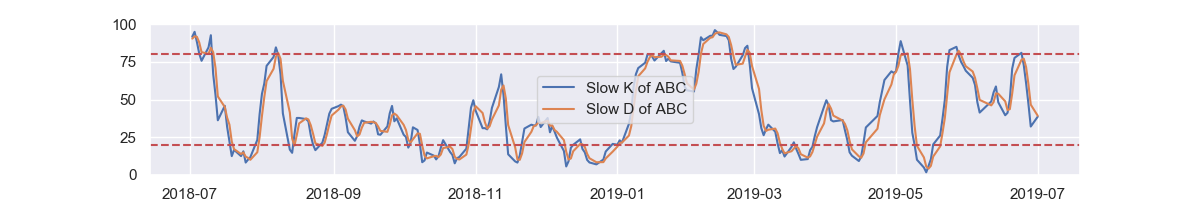

In [19]:
get_plot([stock], stoch=1, size=(12, 2), start='2018-07-01', finish='2019-07-01')

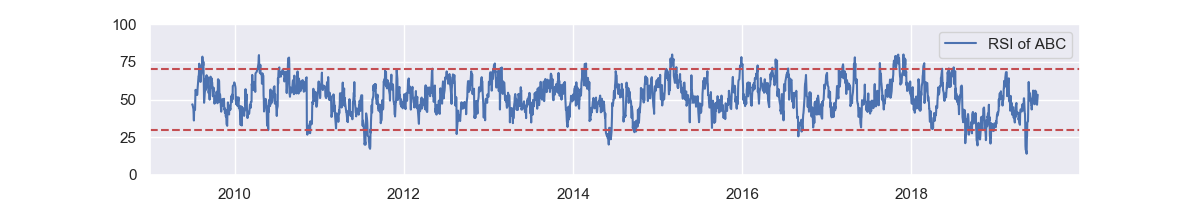

In [14]:
get_plot([stock], rsi=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

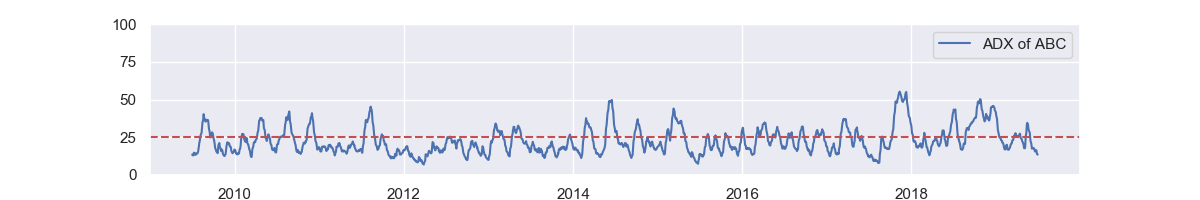

In [15]:
get_plot([stock], adx=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

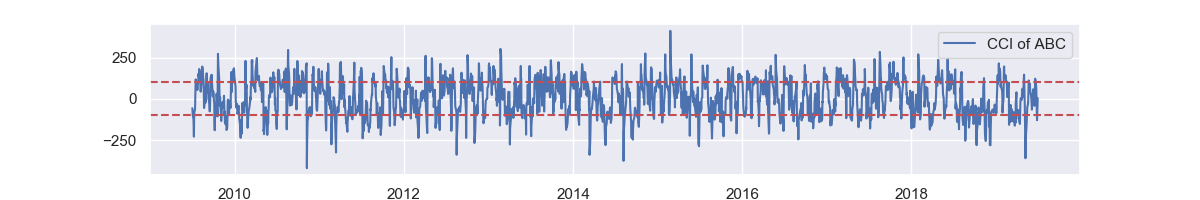

In [16]:
get_plot([stock], cci=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

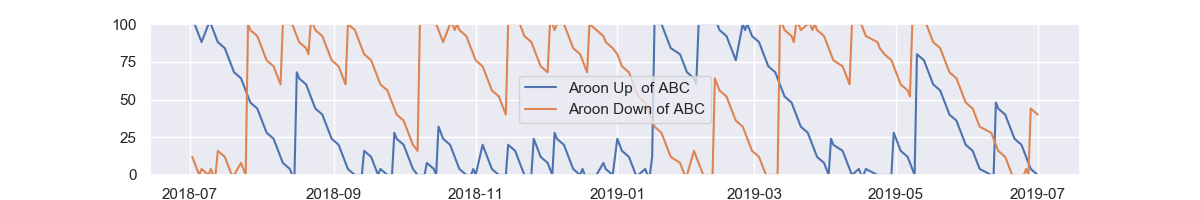

In [20]:
get_plot([stock], aroon=1, size=(12, 2), start='2018-07-01', finish='2019-07-01')

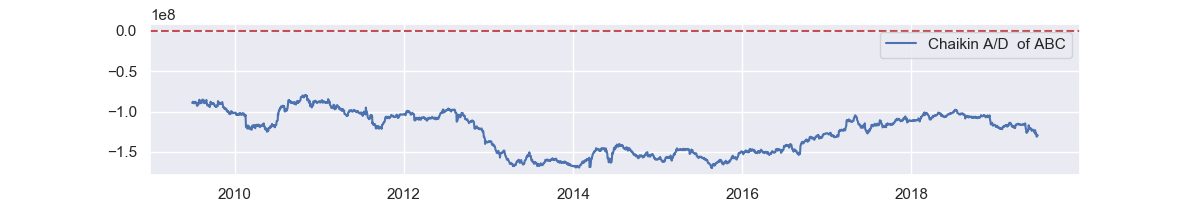

In [18]:
get_plot([stock], chaikin=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

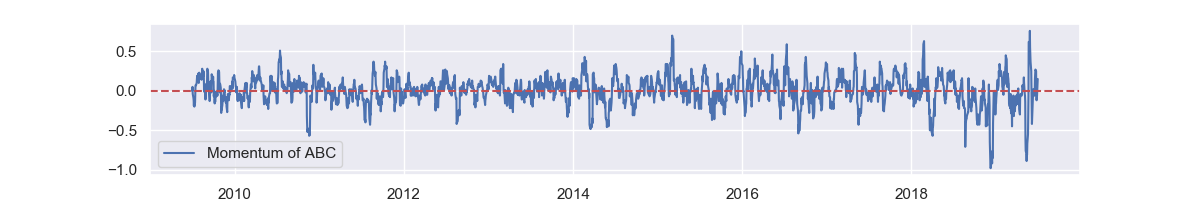

In [19]:
get_plot([stock], mom=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

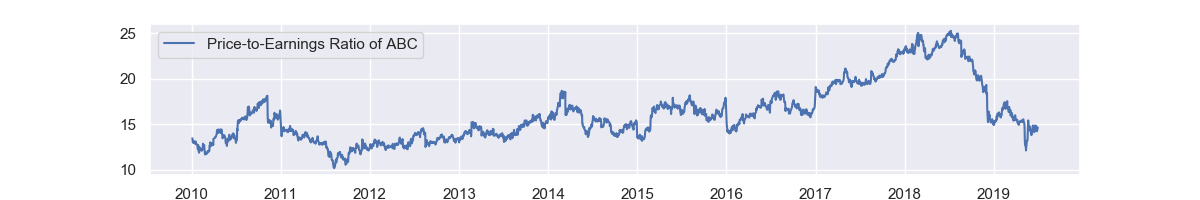

In [20]:
get_plot([stock], pe_ratio=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

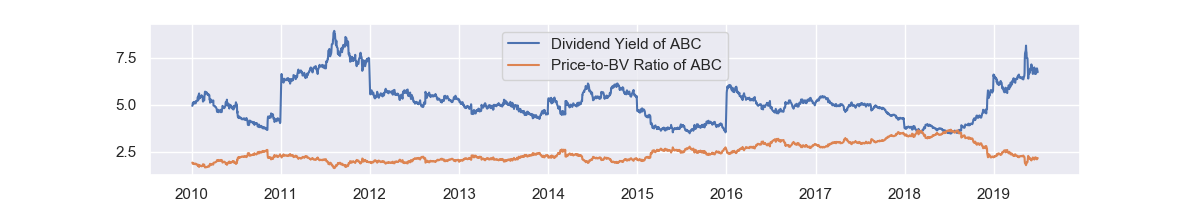

In [21]:
get_plot([stock], dp_ratio=1, pb_ratio=1, size=(12, 2), start='2009-07-01', finish='2019-07-01')

In [40]:
def get_intraday_graph(stocks, norm=None, size=(12,8), engine=engine):
    CSV = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY'\
          '&interval=1min'\
          '&outputsize=full'\
          '&datatype=csv'\
          '&apikey=OW4NZBLAQU5EBFEV'\
          '&symbol='
    
    if len(stocks) > 5:
        raise Exception("Only 5 stocks supported")
    
    if not engine:
        engine = start_engine()

    (x, y) = size
    fig = plt.figure(figsize=(x, y), dpi=100)
    ax = fig.add_subplot()

    for stock in stocks:
        df = pd.read_csv(CSV+stock+'.AX', parse_dates=['timestamp'])
        df['timestamp'] = df['timestamp'].dt.tz_localize('Australia/Sydney')
        df['timestamp'] = df['timestamp'].dt.tz_convert(None)
        cut_off = max(df['timestamp']).date()
        df = df[df['timestamp'] > cut_off]
        cut_off += pd.Timedelta(days=1)
        if norm == 'minmax':
            df['close'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())
        elif norm == 'mean':
            df['close'] = (df['close'] - df['close'].mean()) / df['close'].std()
        plt.plot(df['timestamp'], df['close'], label='%s Stock Price'% stock) 

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.legend()
    plt.title('Intraday Results for %s' % str(cut_off))
    plt.savefig('plot.png', format='png')
    plt.close()     
    img = PIL.Image.open('plot.png')
    return img

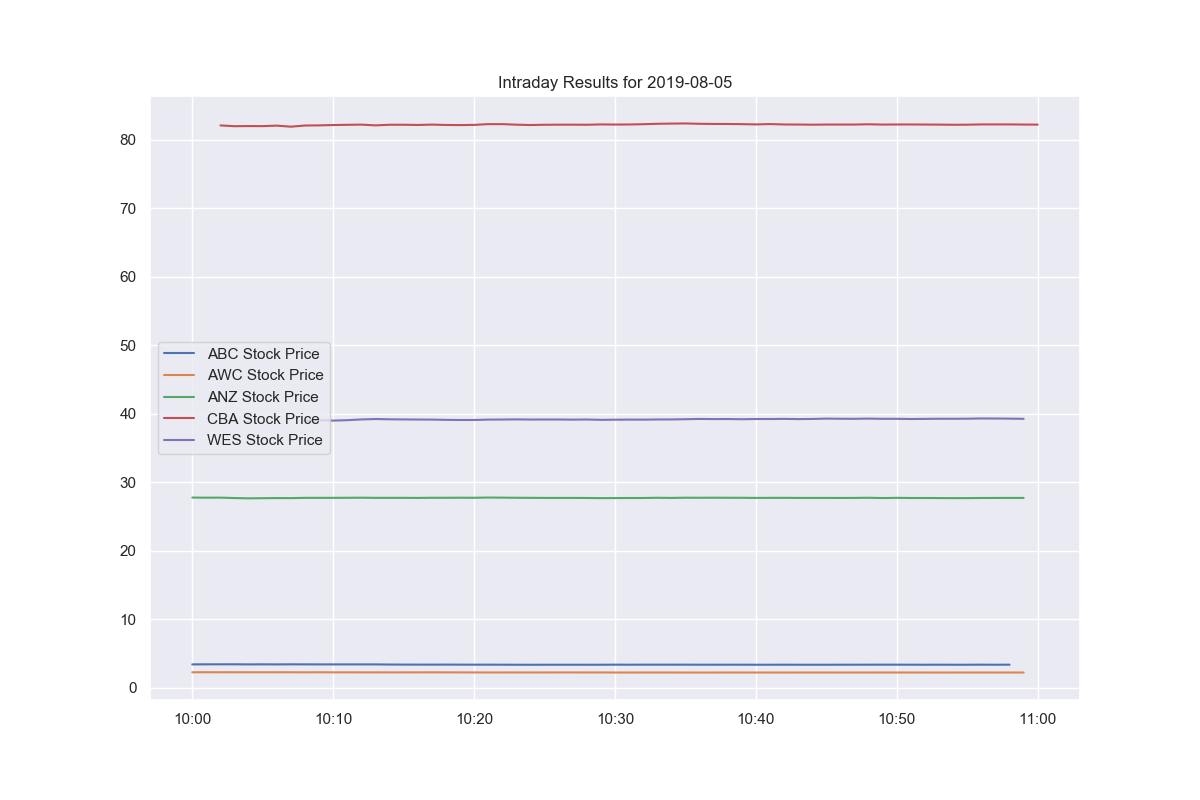

In [41]:
get_intraday_graph(['ABC', 'AWC', 'ANZ', 'CBA', 'WES'])

In [48]:
def get_intraday_candle(stocks, norm=None, size=(12,4), engine=engine):
    CSV = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY'\
          '&interval=1min'\
          '&outputsize=full'\
          '&datatype=csv'\
          '&apikey=OW4NZBLAQU5EBFEV'\
          '&symbol='
    
    if len(stocks) > 5:
        raise Exception("Only 5 stocks supported")
    
    if not engine:
        engine = start_engine()
        
    colors = [
        ['red', 'green'],
        ['blue', 'yellow'],
        ['cyan', 'gray'],
        ['magenta', 'orange'],
        ['pink', 'purple']       
    ]        
        
    fig = go.Figure()
    for stock in stocks:
        (col1, col2) = colors.pop(0)
        df = pd.read_csv(CSV+stock+'.AX', parse_dates=['timestamp'])
        df['timestamp'] = df['timestamp'].dt.tz_localize('Australia/Sydney')
        df['timestamp'] = df['timestamp'].dt.tz_convert(None)
        cut_off = max(df['timestamp']).date()
        df = df[df['timestamp'] > cut_off]
        cut_off += pd.Timedelta(days=1)
        trace = go.Candlestick(x=df['timestamp'],
                               open=df['open'],
                               high=df['high'],
                               low=df['low'],
                               close=df['close'],
                               increasing_line_color=col1,
                               decreasing_line_color=col2,
                               name=stock)
        fig.add_trace(trace)
    fig.update_layout(title=go.layout.Title(text='Intraday Trade Chart', xref="paper", x=0))
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.write_image('candle.png')
    img = PIL.Image.open('candle.png')
    return img  

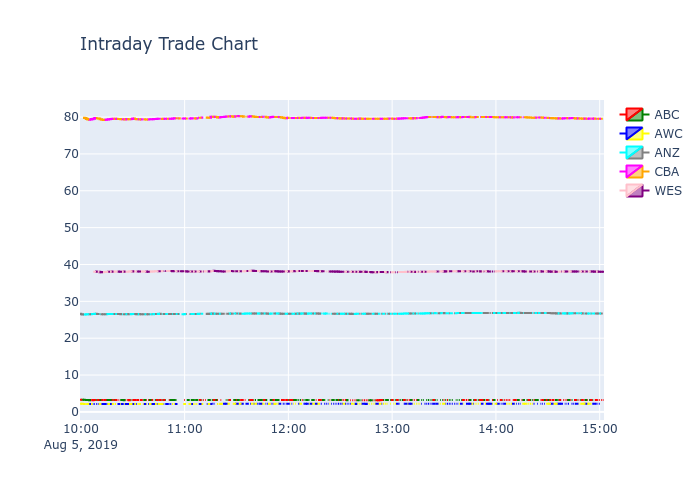

In [49]:
get_intraday_candle(['ABC', 'AWC', 'ANZ', 'CBA', 'WES'])